In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(1)
import skimage.io as io
import tqdm
import os
from fastai.vision.learner import cnn_config
from fastai.callbacks import LossMetrics
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path=Path('/home/staff/xin/Downloads/leafdisease/crowdai/')

In [5]:
src=ImageList.from_folder(path).split_by_rand_pct(seed=2).label_from_folder()

In [6]:
data=(src.transform(get_transforms(),size=256).databunch(bs=8).normalize(imagenet_stats))

In [7]:
from torchvision import models
import torchvision
from Decoder import conv3x3,ConvRelu,DecoderBlock,DecoderBlockV2

In [8]:
class UnetResnet34(nn.Module):
    def __init__(self,
                 num_classes=1,
                 num_filters=32,
                 pretrained=True,
                 is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)        
        
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4
        self.avgpool = self.encoder.avgpool
        self.fc=nn.Linear(in_features=512, out_features=38, bias=True)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)
#         self.ReLU=nn.ReLU(inplace=True)

                
    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
#         print(conv5.shape)
        out1=self.avgpool(conv5)
        out1 = out1.reshape(out1.size(0), -1)
        out1=self.fc(out1)
        center = self.center(self.pool(conv5))
        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)
        x_out = self.final(dec0)
#         x_out = torch.sigmoid(self.final(dec0))
#         x=x_out.expand_as(x)
        x=x*x_out+x
        conv6 = self.conv1(x)
        conv6 = self.conv2(conv6)
        conv6 = self.conv3(conv6)
        conv6 = self.conv4(conv6)
        conv6 = self.conv5(conv6)
        out2=self.avgpool(conv6)
        out2 = out2.reshape(out2.size(0), -1)
        out2=self.fc(out2)
        return out1,out2

In [9]:
import tensorwatch as tw

In [10]:
gc.collect()
learn=None
model=None

In [11]:
class FeatureLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.metric_names = ['aloss','bloss']
        self.aloss=CrossEntropyFlat()
#         self.bloss=nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, input, target):
        target=target.long()
        aloss=self.aloss(input[0],target)
        bloss=self.aloss(input[1],target)
#         bloss=torch.sigmoid(input[1])
#         bloss=bloss[range(len(target)),target].mean()
        loss=aloss+bloss
        outloss=[aloss,bloss]   
        self.metrics=dict(zip(self.metric_names,outloss))
        return loss

In [12]:
def newacc(input, target):
    return accuracy(input[1],target)
    

In [13]:
learn=Learner(data,model=UnetResnet34(),loss_func=FeatureLoss(),metrics=newacc,callback_fns=LossMetrics)

In [19]:
# learn=learn.split(split_model_idx(learn.model,[89]))

In [77]:
xx=iter(learn.data.train_dl)
xb,label=next(xx)

In [78]:
outputs=learn.model(xb)

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [233]:
import tensorwatch as tw

In [234]:
learn.freeze()

In [206]:
learn.lr_find()
learn.recorder.plot()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(5,slice(1e-4))

epoch,train_loss,valid_loss,newacc,aloss,bloss,time
0,0.713064,0.375019,0.940452,0.188633,0.186386,07:05


/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


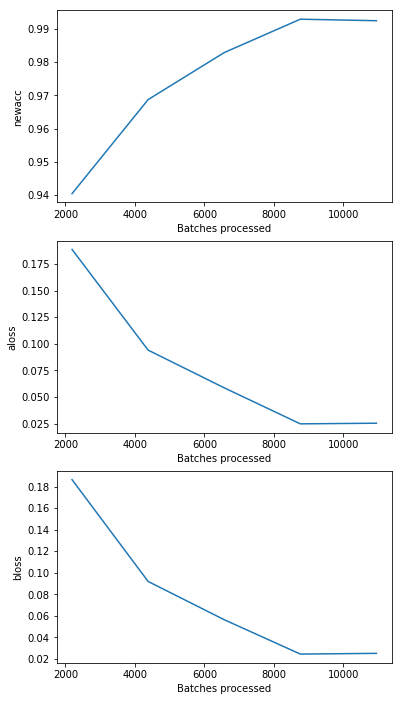

In [16]:
learn.recorder.plot_metrics()

In [60]:
learn.save('unetattall')

# Grad CAM

In [126]:
from fastai.callbacks.hooks import *

In [56]:
i=np.random.randint(17534) #40
test=data.train_ds[i]
sz = list(test[0].shape[-2:])

In [57]:
xb,_ = data.one_item(test[0], detach=False, denorm=False)
xb=xb.float()

In [58]:
m =learn.model.eval().float()
layer1=m.final
with hook_output(layer1) as hook_a:
    preds = m(xb)

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


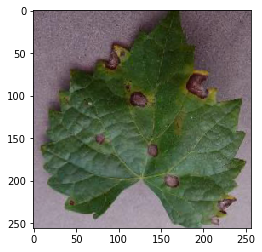

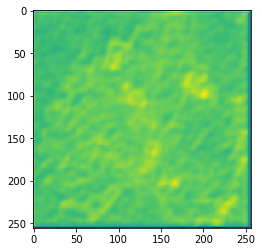

In [59]:
plt.imshow(test[0].data.numpy().transpose(1,2,0))
plt.show()
plt.imshow(hook_a.stored[0,0])

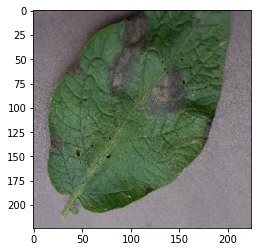

In [171]:
plt.imshow(test[0].data.numpy().transpose(1,2,0))

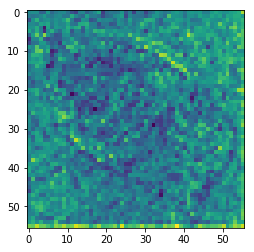

In [72]:
plt.imshow(hook_a.stored.mean(1)[0])

In [76]:
m =learn.model.eval().float()
layer=m.attention2
with hook_output(layer) as hook_a:
    preds = m(xb)
    acts = hook_a.stored[1].cpu()
layer=m.avgpool1
with hook_output(layer) as hook_a:
    with hook_output(layer, grad= True) as hook_g:
        preds = m(xb)
        preds[0,test[1].data].backward()
acts2 = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
mult = F.relu(((acts2*grad_chan[...,None,None])).sum(0))

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


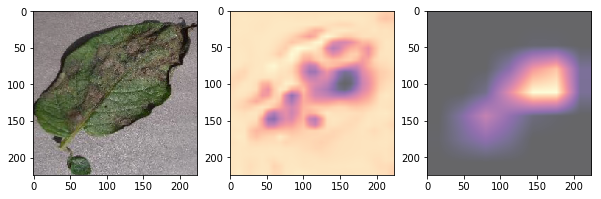

In [79]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test[0].data.numpy().transpose(1,2,0))
# plt.imshow(acts[0,0]>0.2, alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
# plt.imshow(acts[0,0], alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(132)
plt.imshow(acts[0,0], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(133)
plt.imshow(mult, alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')

In [61]:
m =learn.model.eval().float()
layer=m.avgpool


AttributeError: 'Attention' object has no attribute 'avgpool'

# Lime